In [1]:
import itertools
import math
import os
from functools import cache
import random 

import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def plot_hist(data, bins=32):
    data_np = data.flatten().numpy()

    plt.hist(data_np, bins=bins, edgecolor='black')
    plt.title('Гистограмма torch.Tensor')
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    plt.grid(True, alpha=0.3)
    plt.show()

def quantlut_sym(tlut, L, nbits):
    with torch.no_grad():
        lut = torch.arange(1 << L, device=tlut.device)
        lut = (lut + 1) * lut
        sflp = 1 - ((lut >> 15) & 1) * 2
        lut = (lut >> (16 - nbits - 1)) & ((1 << nbits) - 1)
    lut = tlut[lut]
    lut[:, 0] = lut[:, 0] * sflp
    return lut

def quantlut_sym_2d(tlut, L, nbits):
    with torch.no_grad():
        lut = torch.arange(1 << L, device=tlut.device)
        lut = (lut + 1) * lut
        sflp0 = 1 - ((lut >> 15) & 1) * 2
        sflp1 = 1 - ((lut >> 7) & 1) * 2
        lut = (lut >> (16 - nbits - 1)) & ((1 << nbits) - 1)
    lut = tlut[lut] * torch.stack([sflp0, sflp1]).T
    return lut

def create_lowbit_trellis_codebook(base_codebook_size, values_bits, bound):
    n_unique_values = 1 << values_bits
    unique_values = torch.arange(n_unique_values) - n_unique_values // 2

    step = 2 * bound / (n_unique_values - 1)
    offset = step / 2

    unique_values = unique_values * step + offset

    quantiles = torch.special.ndtr(unique_values)

    quantiles_padded = torch.tensor([0] + list(quantiles) + [1])

    quantiles_dif = quantiles_padded[1:] - quantiles_padded[:-1]
    frequences = (quantiles_dif[:-1] + quantiles_dif[1:]) / 2
    counts = frequences * base_codebook_size

    codebook = []
    for i, c in enumerate(counts):
        codebook += max(c.round().int(), 1) * [unique_values[i]]

    def remove_random_elements(lst, k):
        if k >= len(lst):
            return []  # или raise ValueError("k must be less than list length")
        indices_to_remove = random.sample(range(len(lst)), k)
        return [x for i, x in enumerate(lst) if i not in indices_to_remove]

    elems_to_remove = len(codebook) - base_codebook_size
    codebook = remove_random_elements(codebook, elems_to_remove)

    codebook = torch.tensor(codebook)

    return codebook, step, offset

def get_positive_lowbit_codebook(base_codebook_size, values_bits, bound):
    sample_values = int(base_codebook_size * 1.5)
    scale = bound / ((2**(values_bits-1)) - 0.5)

    quantiles = torch.special.ndtr(scale * (torch.arange(2**(values_bits-1))))
    quantiles_padded = torch.tensor(list(quantiles) + [1])
    freq = (quantiles_padded[1:] - quantiles_padded[:-1]).unsqueeze(0)
    freq_2d = freq.T @ freq

    counts = (freq_2d * sample_values / freq_2d.sum())
    counts = counts.round()
    #counts = counts.to(torch.int) + 1
    counts = counts.flatten()

    unique_values = scale * (torch.arange(2**(values_bits-1)) + 0.5)
    unique_cb_h = unique_values.repeat(len(unique_values), 1)
    unique_cb_v = unique_cb_h.T
    unique_cb_2d = torch.stack([unique_cb_v, unique_cb_h], dim=0)

    unique_cb = unique_cb_2d.reshape(2, -1).T

    cb = []
    for i, c in enumerate(counts):
        cb += int(c) * [unique_cb[i],]
        
    cb = torch.stack(cb)
    n_to_remove = len(cb)- base_codebook_size
    cb = cb[torch.randperm(len(cb))][n_to_remove:]

    return cb, scale

def decode_1mad(x):
    x = x.to(torch.int64)
    x = x & ((1 << 32) - 1)
    x = x * 34038481 + 76625530
    x = x & ((1 << 32) - 1)
    y = (x & 255) + ((x >> 8) & 255) + ((x >> 16) & 255) + ((x >> 24) & 255)
    y = y - 510
    y = y.to(torch.float32)
    y = y / 147.800537109375
    return y

def decode_1mad_short(x):
    x = x.to(torch.int64)
    x = x & ((1 << 32) - 1)
    x = x * 34038481 + 76625530
    x = x & ((1 << 32) - 1)
    s = -60
    for i in range(8):
        s += ((x >> (4 * i)) & 15)
    return s * 1.6 / 21.25

def decode_1mad_mid(x):
    x = x.to(torch.int64)
    x = x & ((1 << 32) - 1)
    x = x * 34038481 + 76625530
    x = x & ((1 << 32) - 1)
    
    s = -157.5
    for i in range(5):
        s += ((x >> (6 * i)) & 63)
    return s / 41.31



100%|██████████| 4/4 [00:00<00:00, 12.55it/s]


error: 0.072 +- 0.007
unique values: 16


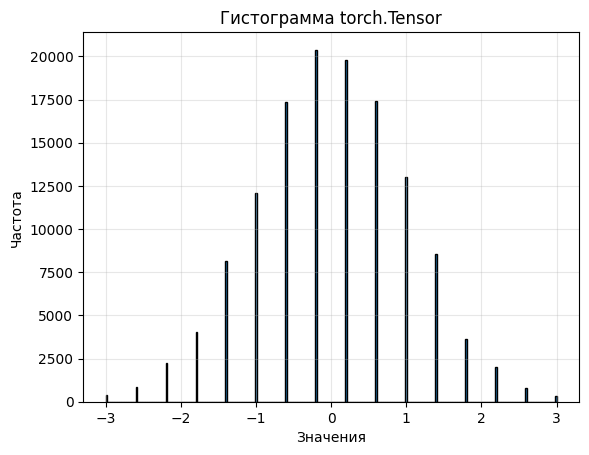

In [4]:
class bitshift_codebook(nn.Module):
    def __init__(self,
                 L=16,
                 K=2,
                 V=2,
                 tlut=None,
                 tlut_bits=9,
                 decode_mode='1mad'):
        super(bitshift_codebook, self).__init__()
        self.idx_dtype = torch.int32
        self.opt_scale = 1

        self.L = L
        self.K = K
        self.V = V
        self.decode_mode = decode_mode

        if decode_mode == '1mad':
            assert V == 1
            self.register_buffer('lut',
                                 decode_1mad(torch.arange(2**L)).unsqueeze(0))
        elif decode_mode == '1mad_short':
            assert V == 1
            self.register_buffer('lut',
                                 decode_1mad_short(torch.arange(2**L)).unsqueeze(0))
        elif decode_mode == '1mad_mid':
            assert V == 1
            self.register_buffer('lut',
                                 decode_1mad_mid(torch.arange(2**L)).unsqueeze(0))
        elif decode_mode == 'smart_lut':
            assert V == 1
            
            nbits = 6
            cb_size = 2**nbits #512 #4096
            
            ### Uniform
            # step = 4 * 2 / cb_size
            # offset = cb_size // 2 - 1
            # smart_cb = step * (torch.arange(cb_size) - offset)
            
            ### Random gaussian
            # smart_cb = torch.randn(256)
            
            smart_cb = torch.distributions.Normal(0, 1).icdf(torch.linspace(0, 1, cb_size + 2)[1:-1]) * 1.1
            #smart_cb = smart_cb[torch.randperm(cb_size)]
            
            lut = torch.arange(1 << L)
            lut = (lut + 1) * lut
            lut = (lut >> (16 - nbits - 1)) & ((1 << nbits) - 1)
            smart_lut = smart_cb[lut]


            #smart_lut = smart_cb[torch.arange(2**L) % cb_size]
            #seed=42
            #torch.manual_seed(seed)
            #shuffled_indices = torch.randperm(2**L)
            #smart_lut = smart_lut[shuffled_indices]


            self.register_buffer('lut',
                                 smart_lut.unsqueeze(0))
        
        elif decode_mode == 'lowbitlut':
            assert V == 1
            # best: base_codebook_size=256, values_bits=4, val_bound=3
            nbits = 8
            base_codebook_size = 2**nbits
            values_bits = 4
            val_bound = 3.0
            smart_cb, scale, offset = create_lowbit_trellis_codebook(base_codebook_size, values_bits, val_bound)
            
            if L==nbits:
               smart_lut = smart_cb[torch.randperm(base_codebook_size)]
            else:
                lut = torch.arange(1 << L)
                lut = (lut + 1) * lut
                lut = (lut >> (16 - nbits - 1)) & ((1 << nbits) - 1)
                smart_lut = smart_cb[lut]

            self.register_buffer('lut',
                                 smart_lut.unsqueeze(0))
        elif decode_mode == 'lowbitlut2d':
            #assert V == 2
            assert L == 16
            nbits = 8
            base_codebook_size = 2**nbits
            values_bits = 4
            val_bound = 3.0
            smart_cb, scale, offset = create_lowbit_trellis_codebook(base_codebook_size, values_bits, val_bound)
            
            cb_h = smart_cb[torch.randperm(base_codebook_size)].repeat(base_codebook_size, 1)
            cb_v = smart_cb[torch.randperm(base_codebook_size)].repeat(base_codebook_size, 1).T
            smart_cb_2d = torch.stack([cb_v, cb_h])
            smart_cb_2d = smart_cb_2d.reshape(-1, 2)[torch.randperm(2**16)].T
            if V==1:        
                self.register_buffer('lut', smart_cb_2d[:1])
            elif V==2:
                self.register_buffer('lut', smart_cb_2d)
        elif decode_mode == 'quantlut_sym':
            if tlut is None:
                assert tlut_bits > 0
                if V == 2:
                    fname = f'/tmp/kmeans_{tlut_bits}_{V}.pt'
                    if not os.path.exists(fname):
                        tlut = torch.randn(2**tlut_bits, V)
                        import scipy
                        data = torch.randn(1 << 20, 2)
                        clusters = scipy.cluster.vq.kmeans(data, tlut)
                        tlut = torch.tensor(clusters[0])
                        tlut = (tlut /
                                tlut.std(unbiased=False)) * 0.9682458365518543
                        torch.save(tlut, fname)
                    else:
                        tlut = torch.load(fname)
                else:
                    raise Exception
                self.register_buffer('tlut', tlut)
                self.register_buffer(
                    'lut',
                    quantlut_sym(self.tlut, L, tlut_bits).T.contiguous())
        elif decode_mode == 'quantlut_sym_2d':
            if tlut is None:
                assert tlut_bits > 0
                if V == 2:
                    fname = f'/tmp/kmeans_{tlut_bits}_{V}.pt'
                    if not os.path.exists(fname):
                        tlut = torch.randn(2**tlut_bits, V)
                        import scipy
                        data = torch.randn(1 << 20, 2)
                        clusters = scipy.cluster.vq.kmeans(data, tlut)
                        tlut = torch.tensor(clusters[0])
                        tlut = (tlut /
                                tlut.std(unbiased=False)) * 0.9682458365518543
                        torch.save(tlut, fname)
                    else:
                        tlut = torch.load(fname)
                else:
                    raise Exception
            self.register_buffer('tlut', tlut)
            self.register_buffer(
                'lut',
                quantlut_sym_2d(self.tlut, L, tlut_bits).T.contiguous())
        else:
            raise Exception

        self.fakeinf = torch.tensor(torch.inf)

        self.register_buffer('sumdelta',
                             torch.arange(2**(K * V)) << (L - K * V))
        self.sumdelta = self.sumdelta.view(1, 1, -1)

        self.register_buffer('state', torch.arange(2**L).unsqueeze(0))
        self.register_buffer('state_cand',
                             (self.state >>
                              (K * V))[0, ::2**(K * V)].unsqueeze(-1) +
                             self.sumdelta)
        self.register_buffer('recons_state', self.recons(self.state))

        self.version = 0

    def recons(self, encoded, **kwargs):
        return self.lut[:,
                        encoded.int().to(self.lut.device)].to(encoded.device)

    @torch.compile
    def update(self, cost, thing):
        state_err = (self.recons_state -
                     thing.unsqueeze(-1)).square().sum(dim=0)
        cand_cost = torch.gather(
            cost.unsqueeze(-2).expand(-1, self.state_cand.shape[1], -1), -1,
            self.state_cand.expand(len(cost), -1, 2**(self.K * self.V)))
        best = torch.min(cand_cost, dim=-1)
        cost = state_err + best.values.unsqueeze(-1).expand(
            -1, -1, 2**(self.K * self.V)).reshape(state_err.shape)
        prev_state = torch.gather(
            self.state_cand.expand(thing.shape[1], -1, -1), -1,
            best.indices.unsqueeze(-1))[..., 0]
        return prev_state, cost

    def viterbi(self, X, overlap=None):
        T, B = X.shape
        assert T % self.V == 0
        # cost is (B, 2**L)
        cost = (self.recons_state -
                X[:self.V].unsqueeze(-1)).square().sum(dim=0)

        if overlap is not None:
            mask = torch.ones(B, 2**self.L, device=X.device) * self.fakeinf
            allow = (overlap <<
                     (self.K * self.V)).unsqueeze(-1) + torch.arange(
                         2**(self.K * self.V)).to(X.device).view(1, 1, -1)
            mask.scatter_(1, allow[0], 0)
            cost = torch.min(cost + mask, self.fakeinf)

        from_state = torch.zeros(T // self.V,
                                 B,
                                 2**(self.L - self.K * self.V),
                                 dtype=self.state.dtype,
                                 device=self.state.device)

        for i in range(1, T // self.V):
            from_state[i], cost = self.update(cost,
                                              X[i * self.V:(i + 1) * self.V])

        if overlap is not None:
            mask = torch.ones(B, 2**self.L, device=X.device) * self.fakeinf
            allow = (overlap.unsqueeze(-1) + self.sumdelta.unsqueeze(0))
            mask.scatter_(1, allow[0, 0], 0)
            cost = torch.min(cost + mask, self.fakeinf)

        final_state = torch.zeros(T // self.V,
                                  B,
                                  dtype=self.idx_dtype,
                                  device=X.device)
        final_state[T // self.V - 1] = torch.argmin(cost, dim=-1)
        for i in range(T // self.V - 1, 0, -1):
            final_state[i - 1] = torch.gather(
                from_state[i], -1,
                (final_state[i].to(torch.int64).unsqueeze(-1)) >>
                (self.K * self.V))[..., 0]
        return final_state

    def quantize_seq(self, X, overlap=None, batch_size='auto', **kwargs):
        T, NO = X.shape
        if batch_size == 'auto':
            bs = min(2**(24 - self.L), NO)
        else:
            bs = batch_size
        pad_amt = math.ceil(NO / bs) * bs - NO
        X = torch.nn.functional.pad(X, (0, pad_amt))
        T, N = X.shape
        X = X.reshape(T, N // bs, bs).transpose(0, 1).contiguous()
        if overlap is not None:
            overlap = torch.nn.functional.pad(overlap, (0, pad_amt))
            overlap = overlap.reshape(N // bs, bs)

        Qidxs = torch.zeros(N // bs,
                            T // self.V,
                            bs,
                            dtype=self.idx_dtype,
                            device=X.device)
        for i in tqdm(range(len(X))):
            b_overlap = None if overlap is None else overlap[i]
            Qidxs[i] = self.viterbi(X[i], overlap=b_overlap)
        Qidxs = Qidxs.transpose(0, 1).reshape(T // self.V, N)[:, :NO]
        return Qidxs

    def quantize(self, X, batch_size='auto', **kwargs):
        X = X.T.contiguous().to(torch.float16)
        T = X.shape[0]
        roll_X = torch.roll(X, T // (2 * self.V) * self.V, 0)
        state = self.quantize_seq(roll_X, overlap=None, batch_size=batch_size)
        overlap = state[T // (2 * self.V)] >> self.K * self.V
        state = self.quantize_seq(X, overlap=overlap, batch_size=batch_size)
        hatX = self.recons(state).transpose(0, 1).reshape(X.shape)
        return hatX.T.contiguous().to(X.device), state.T.contiguous().to(
            X.device)

    def pack_trellis(self, trellis):
        # T is really T // self.V here
        B, T = trellis.shape
        bf = torch.zeros(B,
                         T * self.K * self.V + self.L - self.K * self.V,
                         dtype=bool,
                         device=trellis.device)
        bf[:, :self.L] = (trellis[:, 0].unsqueeze(-1) & (2**torch.arange(
            self.L, device=trellis.device).flip(dims=(-1, ))).unsqueeze(0)) > 0
        K_mask = 2**torch.arange(
            self.K * self.V,
            device=trellis.device).flip(dims=(-1, )).unsqueeze(0)
        for i in range(1, T):
            assert ((trellis[:, i - 1] &
                     ((1 << (self.L - self.K * self.V)) - 1)) == (
                         trellis[:, i] >> (self.K * self.V))).all()
            bf[:,
               (self.L +
                (i - 1) * self.K * self.V):(self.L + i * self.K * self.V)] = (
                    (trellis[:, i] &
                     ((1 <<
                       (self.K * self.V)) - 1)).unsqueeze(-1) & K_mask) > 0

        bf = bf[:, :-(self.L - self.K * self.V)]
        pad_amt = math.ceil(
            T * self.K * self.V / 16) * 16 - T * self.K * self.V
        bf = torch.nn.functional.pad(bf, (0, pad_amt)).reshape(
            -1, (T * self.K * self.V + pad_amt) // 16, 16)

        uint_mask = (2**torch.arange(
            16, dtype=torch.int32,
            device=bf.device)).flip(dims=(-1, )).unsqueeze(0).unsqueeze(0)
        bf_sum = (bf.to(torch.int32) * uint_mask).sum(dim=-1)
        return bf_sum.to(torch.uint16)

    def unpack_trellis(self, packed, T):
        packed = packed.view(torch.uint16).to(torch.int32)
        uint_mask = (2**torch.arange(
            16, dtype=torch.int32,
            device=packed.device)).flip(dims=(-1, )).unsqueeze(0).unsqueeze(0)
        bf = (packed.unsqueeze(-1) & uint_mask) > 0
        pad_amt = math.ceil(T * self.K / 16) * 16 - T * self.K
        bf = bf.reshape(-1, (T * self.K + pad_amt))[:, :T * self.K]
        bf = torch.concat([bf, bf[:, :self.L - self.K * self.V]], dim=-1)
        L_mask = (2**torch.arange(
            self.L, dtype=torch.int32,
            device=packed.device).flip(dims=(-1, ))).unsqueeze(0)
        K_mask = (2**torch.arange(
            self.K * self.V, dtype=torch.int32,
            device=packed.device).flip(dims=(-1, ))).unsqueeze(0)
        trellis = torch.zeros(bf.shape[0],
                              T // self.V,
                              dtype=torch.int32,
                              device=bf.device)
        trellis[:, 0] = (bf[:, :self.L].int() * L_mask).sum(dim=-1)
        for i in range(1, T // self.V):
            trellis[:, i] = ((trellis[:, i-1] << (self.K*self.V)) & ((1 << self.L) - 1)) + \
                (bf[:, self.L + (i-1)*self.K*self.V : self.L + i*self.K*self.V].int() * K_mask).sum(dim=-1)

        return trellis


DEVICE = 'cuda:0'
codebook = bitshift_codebook(
                 L=16,
                 K=2,
                 V=2,
                 #decode_mode='lowbitlut',
                 #decode_mode='1mad'
                 decode_mode='quantlut_sym_2d',
                 tlut_bits=10,
                 tlut=get_positive_lowbit_codebook(2**10, values_bits=4, bound=3.0)[0]
                 ).to(DEVICE)

w = torch.randn(1000, 256).to(DEVICE)
reco, states = codebook.quantize(w)

err = torch.mean((reco - w)**2, axis=-1)
print(f'error: {err.mean().item():.3f} +- {err.std().item():.3f}')

LUT = codebook.lut.cpu()
print('unique values:', len(torch.unique(LUT)))
plot_hist(LUT, bins=256)

In [5]:
indices = codebook#torch.arange(256)

indices_h = indices.repeat(256, 1)

indices_v = indices_h.T

indices_2d = torch.stack([indices_v, indices_h])

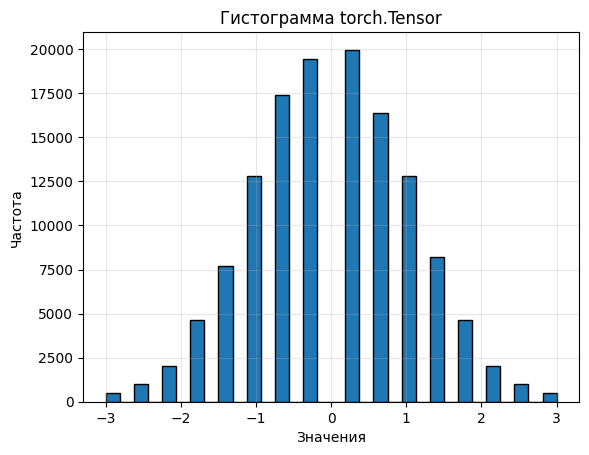

In [6]:
indices_2d[:, 128, 0]
plot_hist(indices_2d, bins=32)

In [7]:
from transformers import AutoModelForCausalLM
import sys
sys.path.append("/home/msst/repo/Quantization")

from qlib.utils.incoherence_preprocessing.matmul_had import (
    matmul_hadU_cuda, matmul_hadU, matmul_hadUt_cuda, matmul_hadUt
)

model = AutoModelForCausalLM.from_pretrained(
    '/home/msst/repo/Quantization/ml/llm/pretrained_models/Llama2-7b-hf', 
    torch_dtype=torch.float16
)

DEVICE = 'cuda:0'

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f004ab42770>>
Traceback (most recent call last):
  File "/home/msst/miniconda3/envs/qenv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
def incoherence_preprocess(W):
    dtype_ = torch.float32
    device = W.device
    (m, n) = W.shape

    use_func = matmul_hadUt_cuda if W.is_cuda else matmul_hadUt

    Wr = W

    # randomized hadamard transformation on W
    SU = (torch.randn(n, device=device).sign() + 1e-5).sign().to(dtype_)
    SV = (torch.randn(m, device=device).sign() + 1e-5).sign().to(dtype_)
    Wr = use_func(use_func(W.T * SV).T * SU)

    SV = SV.cpu()
    SU = SU.cpu()

    Wr = Wr.to(device)

    return Wr, SU, SV

def incoherence_process(hatWr, SU, SV):
    device = hatWr.device

    use_func = matmul_hadU_cuda if hatWr.is_cuda else matmul_hadU

    # reverse hadamard transformation
    hatWr = (use_func(
        (use_func(hatWr) * SU.to(device)).T) * SV.to(device)).T

    assert torch.isfinite(hatWr).all()
    return hatWr

In [4]:
# ### Without incoherence processing
# vecdim=256

# with torch.no_grad():
#     w = model.get_decoder().layers[0].mlp.down_proj.weight

#     w = w.reshape(-1, vecdim).to(DEVICE)
#     w_std = w.std()
#     w_scaled = w / w_std

#     codebook = bitshift_codebook(
#                     L=8, K=2, V=1,
#                     decode_mode='lowbit_lut',
#                     #decode_mode='1mad'
#                     ).to(DEVICE)


#     reco_scaled, states = codebook.quantize(w_scaled, batch_size=1024)
#     reco = reco_scaled * w_std

#     err = torch.mean((reco - w)**2)
#     print(f'error: {err.item():.2e}')


In [ ]:
### WITH incoherence processing
vecdim=256

with torch.no_grad():
    w = model.get_decoder().layers[0].mlp.down_proj.weight
    w_inc, SU, SV = incoherence_preprocess(w)
    w_std = w_inc.std()
    
    w_inc = w_inc.reshape(-1, vecdim).to(DEVICE)
    w_inc_scaled = w_inc / w_std

    codebook = bitshift_codebook(
                    L=15, K=2, V=1,
                    decode_mode='lowbit_lut',
                    #decode_mode='1mad'
                    ).to(DEVICE)

    reco_inc_scaled, states = codebook.quantize(w_inc_scaled, batch_size=256)
    reco_inc = reco_inc_scaled * w_std

    reco_inc = reco_inc.reshape_as(w)
    reco = incoherence_process(reco_inc, SU, SV)
    
    err = torch.mean((reco.cpu() - w.cpu())**2)
    print(f'error: {err.item():.2e}')

### layers[0].mlp.down_proj, L=12
# '1mad' : 2.11e-05
# 'lowbit_lut': 2.10e-05

### layers[0].mlp.down_proj, L=14
# '1mad' : 2.00e-05
# 'lowbit_lut': 1.98e-05

### layers[0].mlp.down_proj, L=15
# '1mad' : 1.97e-05
# 'lowbit_lut': 1.95e-05

100%|██████████| 688/688 [01:47<00:00,  6.39it/s]


error: 1.95e-05


Linear: X @ W.T [B x IN] @ [OUT x IN].T = [B x OUT]
Hadamar: SU [IN] SV [OUT]
         Wr = V.T @ W @ U = (W.T @ V).T @ U

         W = V @ Wr @ U.T = (U @ Wr.T @ V.T).T = ((Wr @ U.T).T @ V.T).T
         
          = (Wr.T @ V.T).T @ U.T

In [6]:
import torch
torch.cuda.is_available()

True

In [ ]:
import sys
sys.path.append("/home/msst/repo/Quantization")

import torch
import torch.nn.functional as F
from qlib.utils.incoherence_preprocessing.matmul_had import (
    matmul_hadU_cuda, matmul_hadU, matmul_hadUt_cuda, matmul_hadUt
)
DEVICE = 'cuda'


W = torch.randn(128, 256).cuda()#to(DEVICE)
X = torch.randn(16, 256).cuda()#.to(DEVICE)

res = F.linear(weight=W, input=X)

In [8]:
if DEVICE == 'cpu':
    had_right_T = matmul_hadUt
    had_right = matmul_hadU
else:
    had_right_T = matmul_hadUt_cuda
    had_right = matmul_hadU_cuda

def incoherence_transform(W):
    dtype_ = torch.float32
    device = W.device
    (m, n) = W.shape

    SU = (torch.randn(n, device=device).sign() + 1e-5).sign().to(dtype_)
    SV = (torch.randn(m, device=device).sign() + 1e-5).sign().to(dtype_)

    Wr = had_right_T(SU * (had_right_T(SV * W.T)).T)

    SV = SV.cpu()
    SU = SU.cpu()

    Wr = Wr.to(device)

    return Wr, SU, SV

In [9]:
def incoherence_preprocess(W):
    dtype_ = torch.float32
    device = W.device
    (m, n) = W.shape

    use_func = matmul_hadUt_cuda if W.is_cuda else matmul_hadUt

    Wr = W

    # randomized hadamard transformation on W
    SU = (torch.randn(n, device=device).sign() + 1e-5).sign().to(dtype_)
    SV = (torch.randn(m, device=device).sign() + 1e-5).sign().to(dtype_)
    Wr = use_func(use_func(W.T * SV).T * SU)

    SV = SV.cpu()
    SU = SU.cpu()

    Wr = Wr.to(device)

    return Wr, SU, SV

def incoherence_process(hatWr, SU, SV):
    device = hatWr.device

    use_func = matmul_hadU_cuda if hatWr.is_cuda else matmul_hadU

    # reverse hadamard transformation
    hatWr = (use_func((use_func(hatWr) * SU.to(device)).T) * SV.to(device)).T

    assert torch.isfinite(hatWr).all()
    return hatWr

In [10]:
#w_inc, SU, SV = incoherence_preprocess(W)
w_inc, SU, SV = incoherence_transform(W)

print(SU.shape, SV.shape)

res_1 = F.linear(weight=incoherence_process(w_inc, SU, SV), input=X)

print(((res - res_1)**2).sum())

torch.Size([256]) torch.Size([128])
tensor(3.0597e-08, device='cuda:0')


In [11]:
w_inc, SU, SV = incoherence_preprocess(W)

res_1 = F.linear(weight=w_inc, input=incoherence_process(X, SU, SV))

print(((res - res_1)**2).sum())

RuntimeError: The size of tensor a (16) must match the size of tensor b (128) at non-singleton dimension 1